# Laboratorium 3 - Drzewa decyzyjne

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from ucimlrepo import fetch_ucirepo
from ydata_profiling import ProfileReport
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score\
, precision_score\
, recall_score\
, f1_score\
, classification_report\
, confusion_matrix\
, RocCurveDisplay\
, roc_curve\
, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.tree import DecisionTreeClassifier, plot_tree

## SECONDARY MUSHROOM

### 1. Załadowanie zbioru, wstępna analiza

In [44]:
mushroom = fetch_ucirepo(id=848) 

df = mushroom.data.original
df.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,p,15.26,x,g,o,f,e,NaN,w,16.95,...,s,y,w,u,w,t,g,NaN,d,w
1,p,16.60,x,g,o,f,e,NaN,w,17.99,...,s,y,w,u,w,t,g,NaN,d,u
2,p,14.07,x,g,o,f,e,NaN,w,17.80,...,s,y,w,u,w,t,g,NaN,d,w
3,p,14.17,f,h,e,f,e,NaN,w,15.77,...,s,y,w,u,w,t,p,NaN,d,w
4,p,14.64,x,h,o,f,e,NaN,w,16.53,...,s,y,w,u,w,t,p,NaN,d,w


In [45]:
print(mushroom.metadata.abstract)

Dataset of simulated mushrooms for binary classification into edible and poisonous.


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

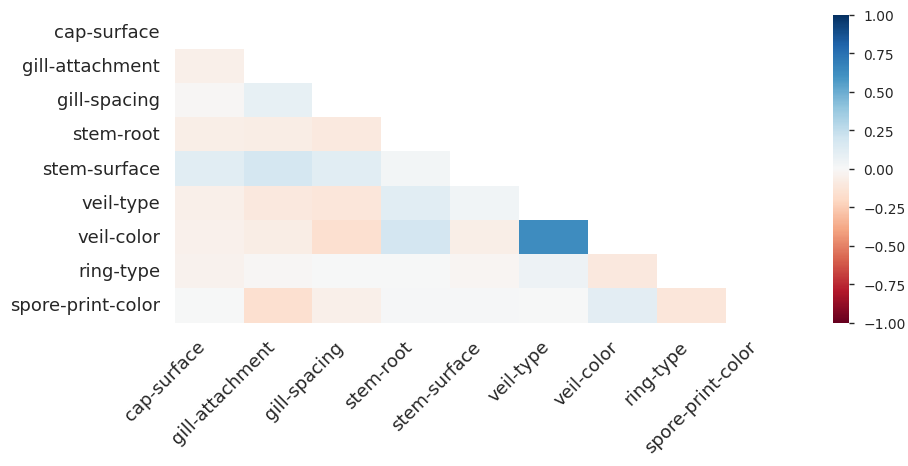

In [47]:
profile = ProfileReport(df, title="Profiling Report")
profile.to_widgets()

In [48]:
# Procentowa ilość brakujących wartości
round((df.isna().sum() / len(df)) * 100, 2).astype(str) + '%'

class                     0.0%
cap-diameter              0.0%
cap-shape                 0.0%
cap-surface             23.12%
cap-color                 0.0%
does-bruise-or-bleed      0.0%
gill-attachment         16.18%
gill-spacing            41.04%
gill-color                0.0%
stem-height               0.0%
stem-width                0.0%
stem-root               84.39%
stem-surface            62.43%
stem-color                0.0%
veil-type                94.8%
veil-color              87.86%
has-ring                  0.0%
ring-type                4.05%
spore-print-color        89.6%
habitat                   0.0%
season                    0.0%
dtype: object

### 2. Preprocessing danych

In [49]:
def clear_na(df = df):

    df = df.drop(['spore-print-color', 
                'veil-color', 
                'veil-type', 
                'stem-surface', 
                'stem-root', 
                'gill-spacing', 
                'gill-attachment', 
                'cap-surface'], axis = 1).reset_index(drop = True)
    df['ring-type'] = df['ring-type'].fillna(df['ring-type'].mode()[0])
    
    return df

df = clear_na()
df.head()

,class,cap-diameter,cap-shape,cap-color,does-bruise-or-bleed,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season
0,p,15.26,x,o,f,w,16.95,17.09,w,t,g,d,w
1,p,16.60,x,o,f,w,17.99,18.19,w,t,g,d,u
2,p,14.07,x,o,f,w,17.80,17.74,w,t,g,d,w
3,p,14.17,f,e,f,w,15.77,15.98,w,t,p,d,w
4,p,14.64,x,o,f,w,16.53,17.20,w,t,p,d,w


In [50]:
# Procentowa ilość brakujących wartości
round((df.isna().sum() / len(df)) * 100, 2).astype(str) + '%'

class                   0.0%
cap-diameter            0.0%
cap-shape               0.0%
cap-color               0.0%
does-bruise-or-bleed    0.0%
gill-color              0.0%
stem-height             0.0%
stem-width              0.0%
stem-color              0.0%
has-ring                0.0%
ring-type               0.0%
habitat                 0.0%
season                  0.0%
dtype: object

In [51]:
df.dtypes

class                    object
cap-diameter            float64
cap-shape                object
cap-color                object
does-bruise-or-bleed     object
gill-color               object
stem-height             float64
stem-width              float64
stem-color               object
has-ring                 object
ring-type                object
habitat                  object
season                   object
dtype: object

In [52]:
# Kodowanie zmiennych kategorycznych
def encode_cat(df = df):
    
    cat_names = df.columns.tolist()
    for element in df.select_dtypes(include = ['float']).columns.tolist():
        cat_names.remove(element)
    for column in cat_names:
        if df[column].nunique() == 2:
            cat_names.remove(column)
    df = pd.get_dummies(df, columns = cat_names, prefix = cat_names, prefix_sep = '_').replace({True: 1, False: 0})
    df['has-ring'] = df['has-ring'].replace({'t': 1, 'f': 0})
    df['does-bruise-or-bleed'] = df['does-bruise-or-bleed'].replace({'t': 1, 'f': 0})
    df['class'] = df['class'].replace({'p': 1, 'e': 0})
    return df

df_dummy = encode_cat()
df_dummy.head()

,class,cap-diameter,does-bruise-or-bleed,stem-height,stem-width,has-ring,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_o,...,habitat_h,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w,season_a,season_s,season_u,season_w
0,1,15.26,0,16.95,17.09,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,16.60,0,17.99,18.19,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1,14.07,0,17.80,17.74,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,14.17,0,15.77,15.98,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,1,14.64,0,16.53,17.20,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


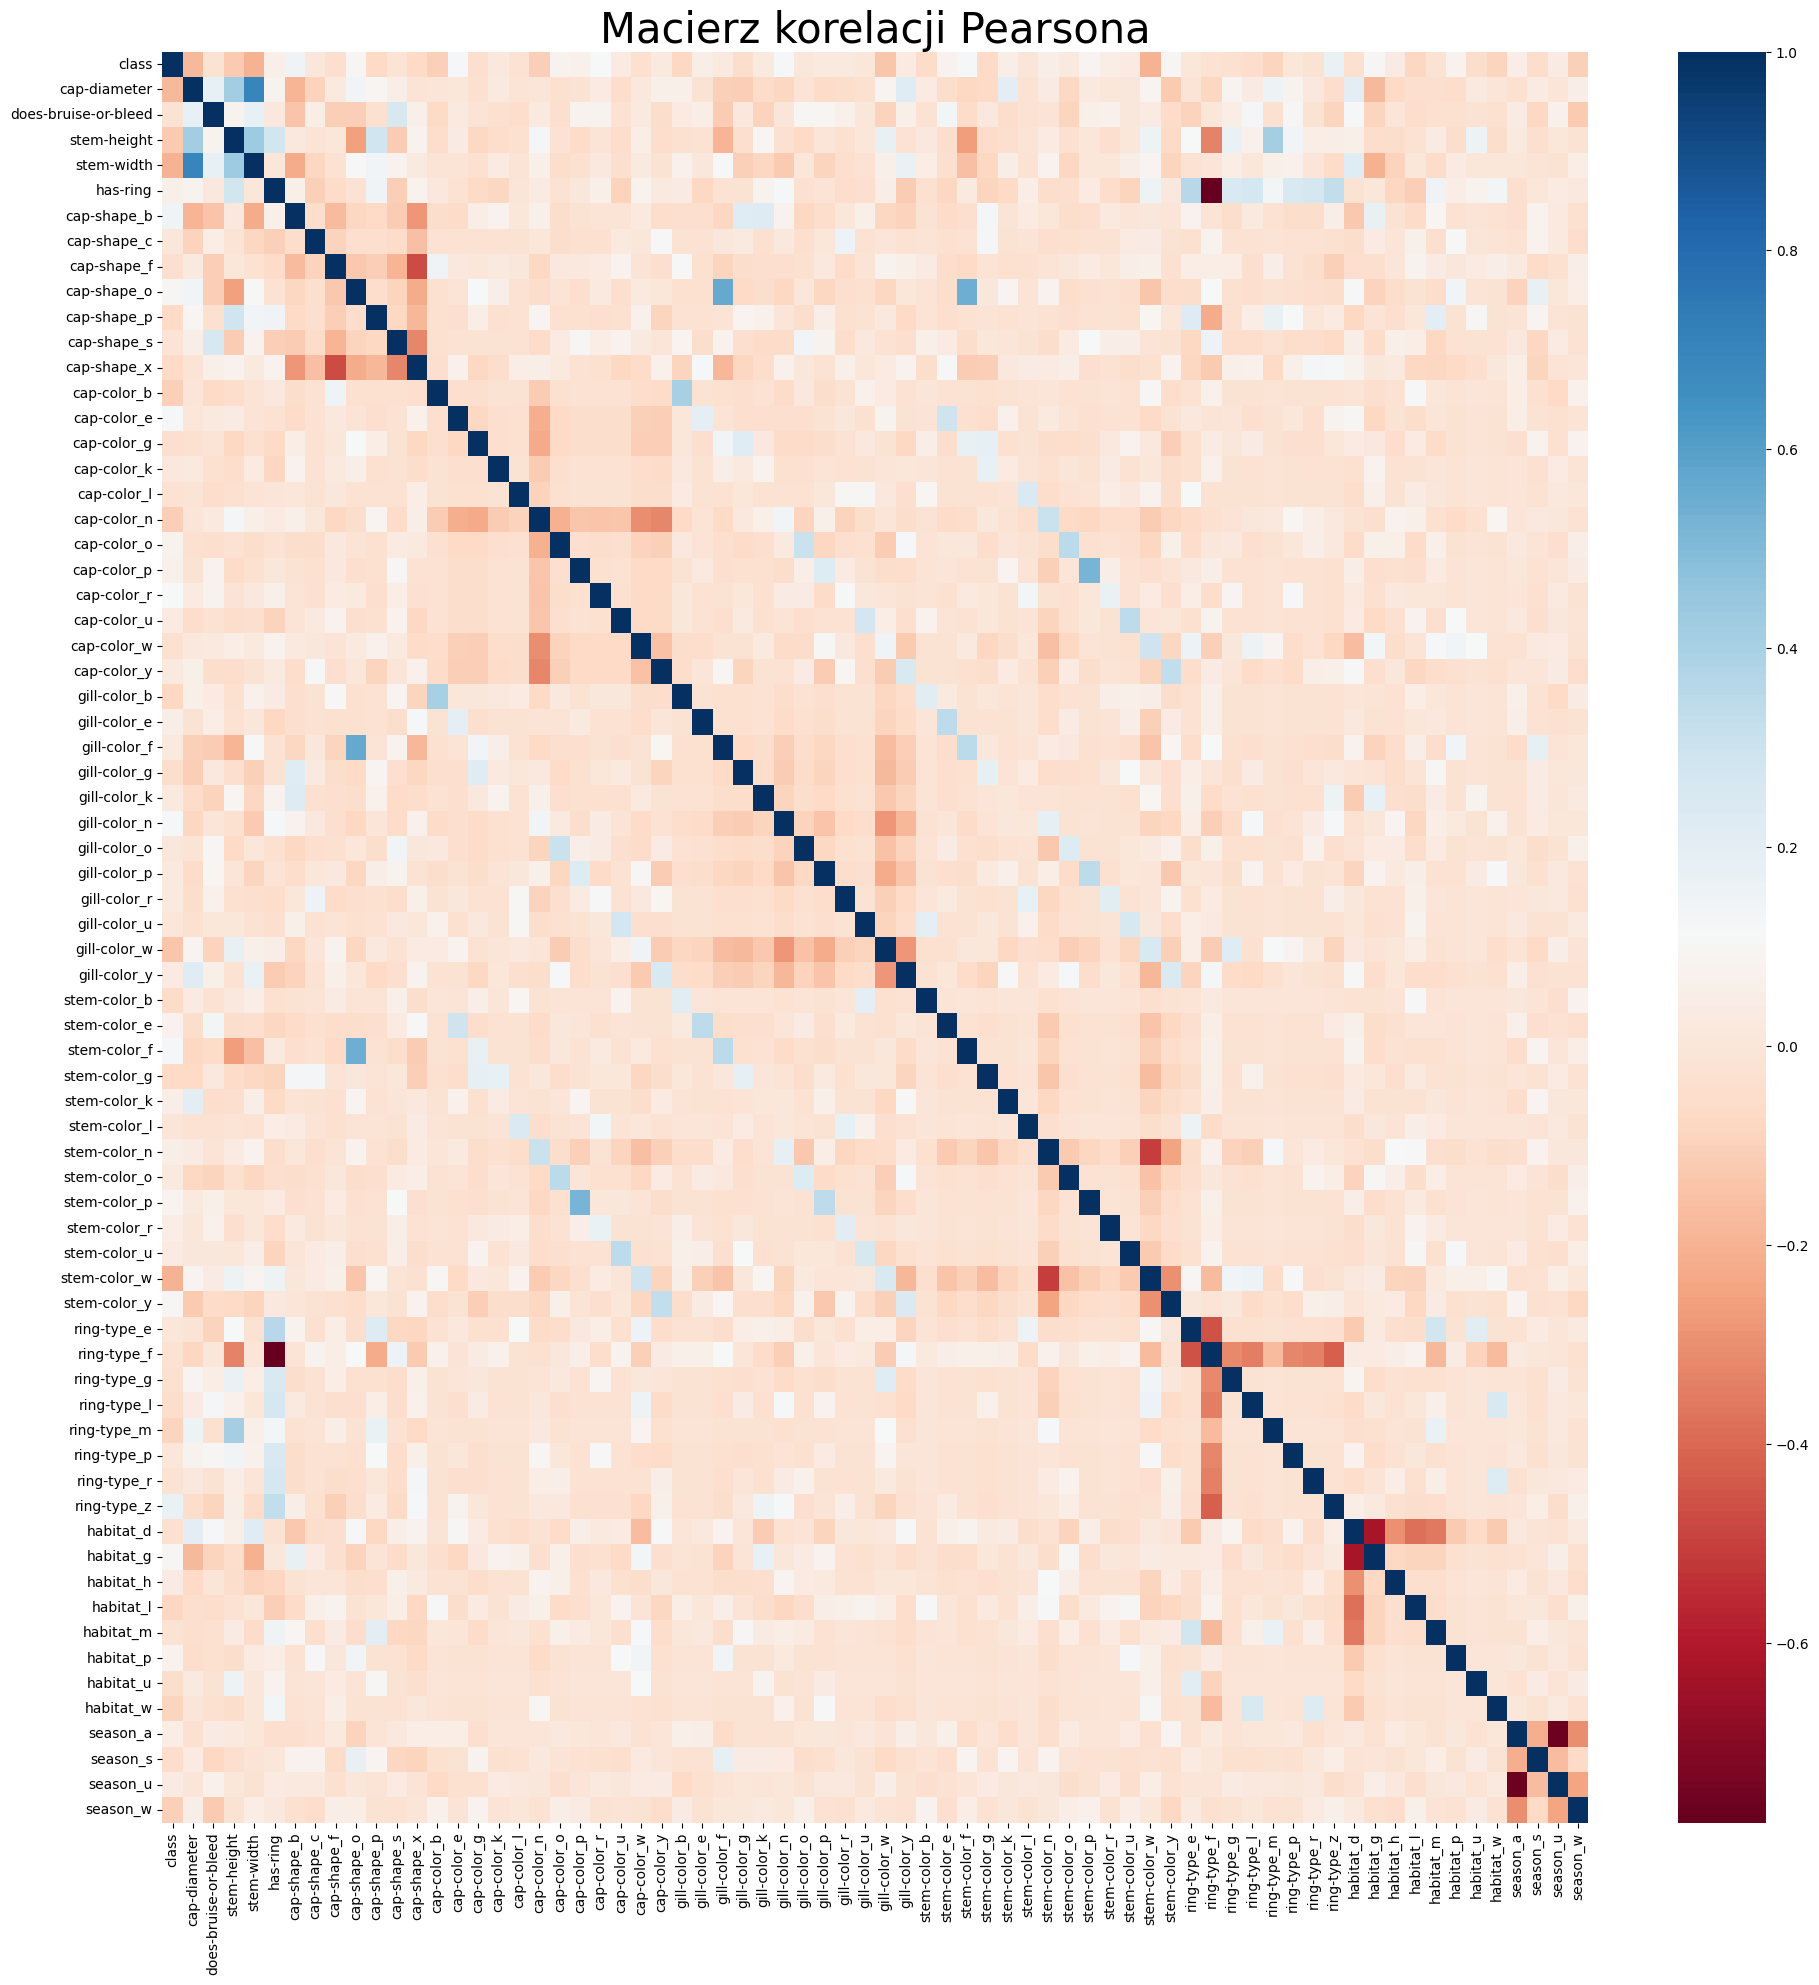

In [53]:
df_corr = df_dummy.corr()
pearson_corr_features = df_corr.index

plt.figure(figsize = (23, 23))
sns.heatmap(df_dummy[pearson_corr_features].corr(), cmap = 'RdBu')
plt.title('Macierz korelacji Pearsona', fontsize = 30)
plt.show()

Po przeanalizowaniu danych postanowiłem dokonać kilku czynności mających na celu przygotowanie danych do modelowania:
* Usunięcie kolumn z dużą ilością nulli. W przypadku kolumny **ring-type** gdzie ilość braków wynosiła ok. 4%, zostały one uzupełnione najczęściej występującą wartością (klasa ta była wyraźnie tendencyjna)
* Zakodowanie zmiennych kategorycznych korzystając z **pd.get_dummies()** (w przypadku zmiennych wieloklasowych)
* Po przeanalizowaniu macierzy korelacji, stwierdziłem że na razie nie ma potrzeby odrzucania wybranych cech
* Obsługa outlierów z wykorzystaniem funkcji **clip()** - zostanie ona jednak dokonana po podziale zbioru na treningowy i testowy, aby uniknąć przecieku danych.

### 3. Trenowanie drzewa

In [54]:
train, test = train_test_split(df_dummy, stratify = df_dummy['class'], shuffle = True)
train, test = train.reset_index(drop = True), test.reset_index(drop = True)

In [55]:
train.head()

,class,cap-diameter,does-bruise-or-bleed,stem-height,stem-width,has-ring,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_o,...,habitat_h,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w,season_a,season_s,season_u,season_w
0,1,3.72,0,5.09,3.14,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1,1,11.06,0,9.79,12.66,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,0,2.93,1,4.31,5.37,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
3,1,3.79,0,4.98,6.36,0,0,0,1,0,...,0,1,0,0,0,0,1,0,0,0
4,1,3.40,0,4.12,3.29,1,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [57]:
def draw_boxplots(df = train):
    only_num = df[df.select_dtypes(include = ['float']).columns.tolist()]

    plt.figure(figsize = (20, 10))
    sns.boxplot(only_num)
    plt.title('Rozkład zmiennych numerycznych', fontsize = 30)
    plt.show()

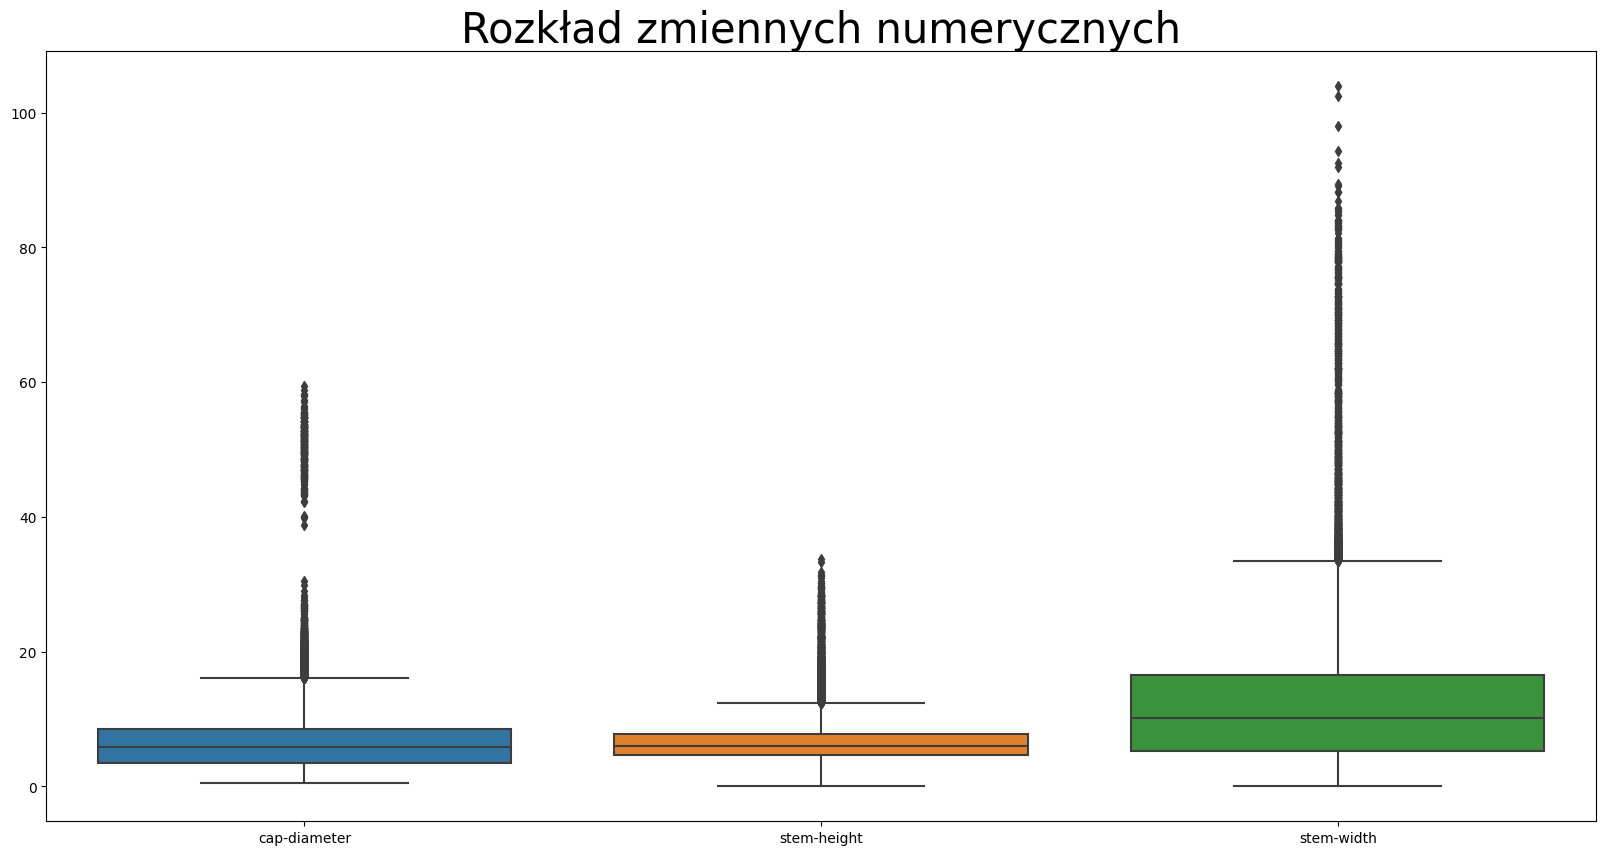

In [58]:
draw_boxplots()

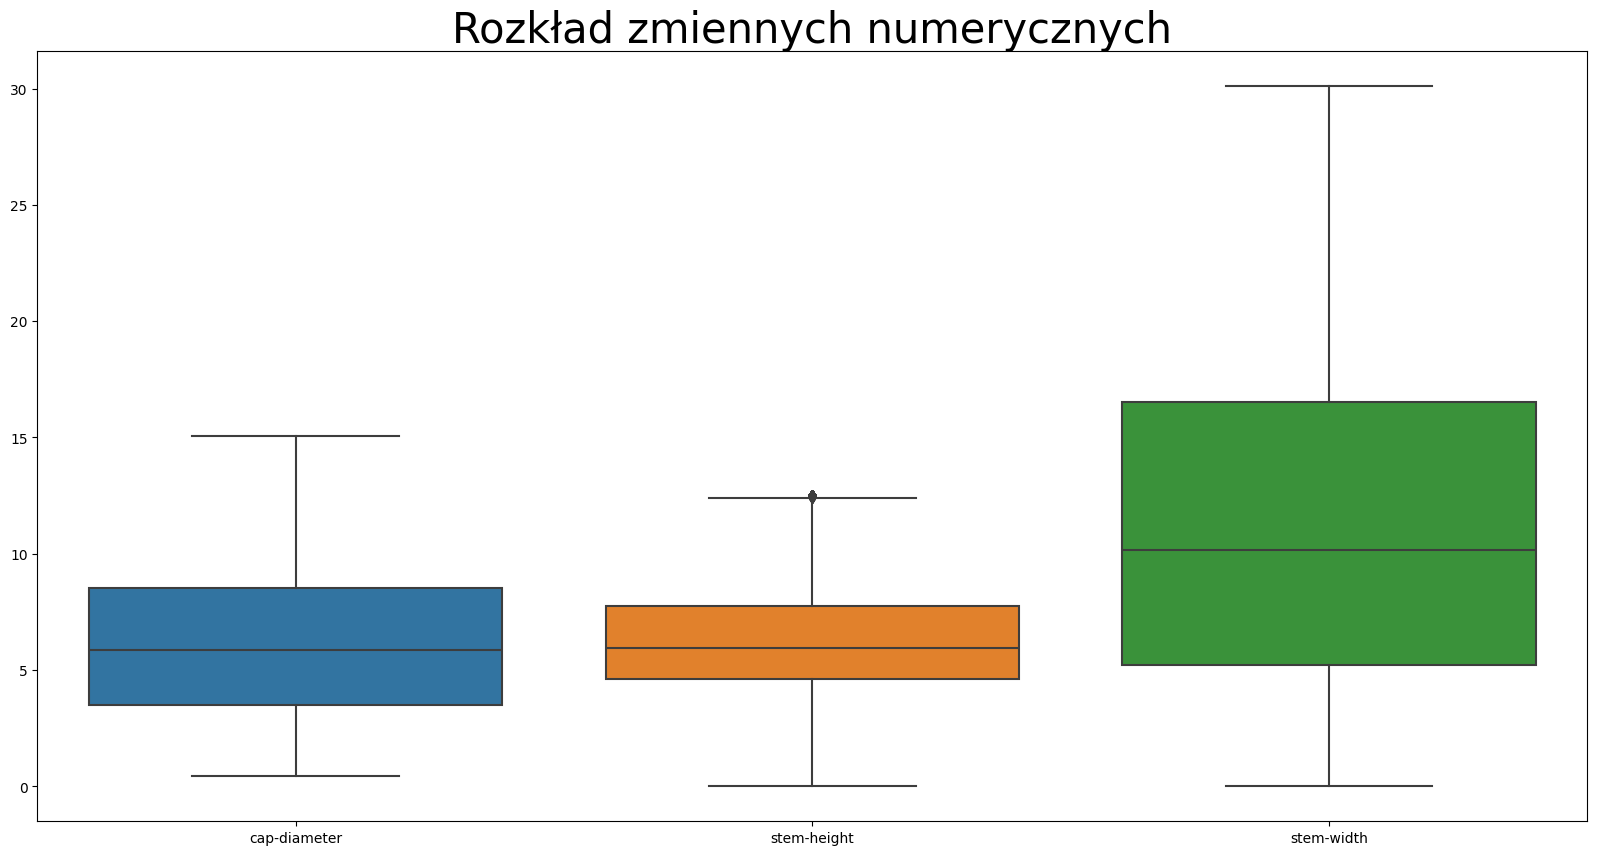

In [59]:
def remove_outliers(df, alpha = 0.05):
    num_names = df.select_dtypes(include = ['float']).columns.tolist()
    df[num_names] = df[num_names].clip(lower = df[num_names].quantile(0), upper = df[num_names].quantile(1 - alpha), axis = 1)
    return df

train = remove_outliers(train)
draw_boxplots()

Jak możemy zauważyć, wśród zmiennych numerycznych występowały outliery, co można było zauważyć na boxplotach. Po ich obróbce, rozkłady zmiennych prezentują się znacznie lepiej.

In [ ]:
X, y = np.array(train.iloc[:, 1:]), np.array(train.iloc[:, 0]).reshape(1, -1)[0]

In [67]:
def tree_model(X, y):
    
    param_grid = {
        'max_depth' : [(i + 1) for i in range(24, 40)] # wcxeśniej był przetestowany zakres [1, 30] i wychodziła maksymalna głębokość
        , 'criterion' : ['gini', 'entropy']
        , 'min_samples_leaf' : [(i + 1) for i in range(10)]
        }
    
    kf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
    grid_search = GridSearchCV(estimator = DecisionTreeClassifier(), param_grid = param_grid, cv = kf, n_jobs = -1, verbose = 1)
    grid_search.fit(X, y)
    
    return grid_search.best_params_, grid_search.best_score_, grid_search.best_estimator_

In [68]:
best_params, best_score, best_model = tree_model(X, y)

Fitting 10 folds for each of 320 candidates, totalling 3200 fits


In [69]:
print(best_params)
print(best_score)
print(best_model)

{'criterion': 'entropy', 'max_depth': 35, 'min_samples_leaf': 1}
0.9912066455879
DecisionTreeClassifier(criterion='entropy', max_depth=35)


### 4. Testowanie modelu na zbiorze testowym

In [70]:
def print_metrics(y_test, y_pred):
    print(classification_report(y_test, y_pred))
    print('\n')
    print(f'Precision: {precision_score(y_test, y_pred, average = "weighted")}')
    print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
    print(f'Recall: {recall_score(y_test, y_pred, average = "weighted")}')
    print(f'F1: {f1_score(y_test, y_pred, average = "weighted")}')

In [71]:
def tree_plot(tree, feature_names, class_names):
    fig = plt.figure(figsize=(25,20))
    _ = plot_tree(tree, 
                   feature_names = feature_names,  
                   class_names = class_names,
                   filled=True)

In [72]:
X_train, y_train = np.array(train.iloc[:, 1:]), np.array(train.iloc[:, 0]).reshape(1, -1)[0]
X_test, y_test = np.array(test.iloc[:, 1:]), np.array(test.iloc[:, 0]).reshape(1, -1)[0]

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

In [73]:
print_metrics(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6796
           1       0.99      0.99      0.99      8472

    accuracy                           0.99     15268
   macro avg       0.99      0.99      0.99     15268
weighted avg       0.99      0.99      0.99     15268



Precision: 0.989913659150664
Accuracy: 0.9899135446685879
Recall: 0.9899135446685879
F1: 0.9899122088743157


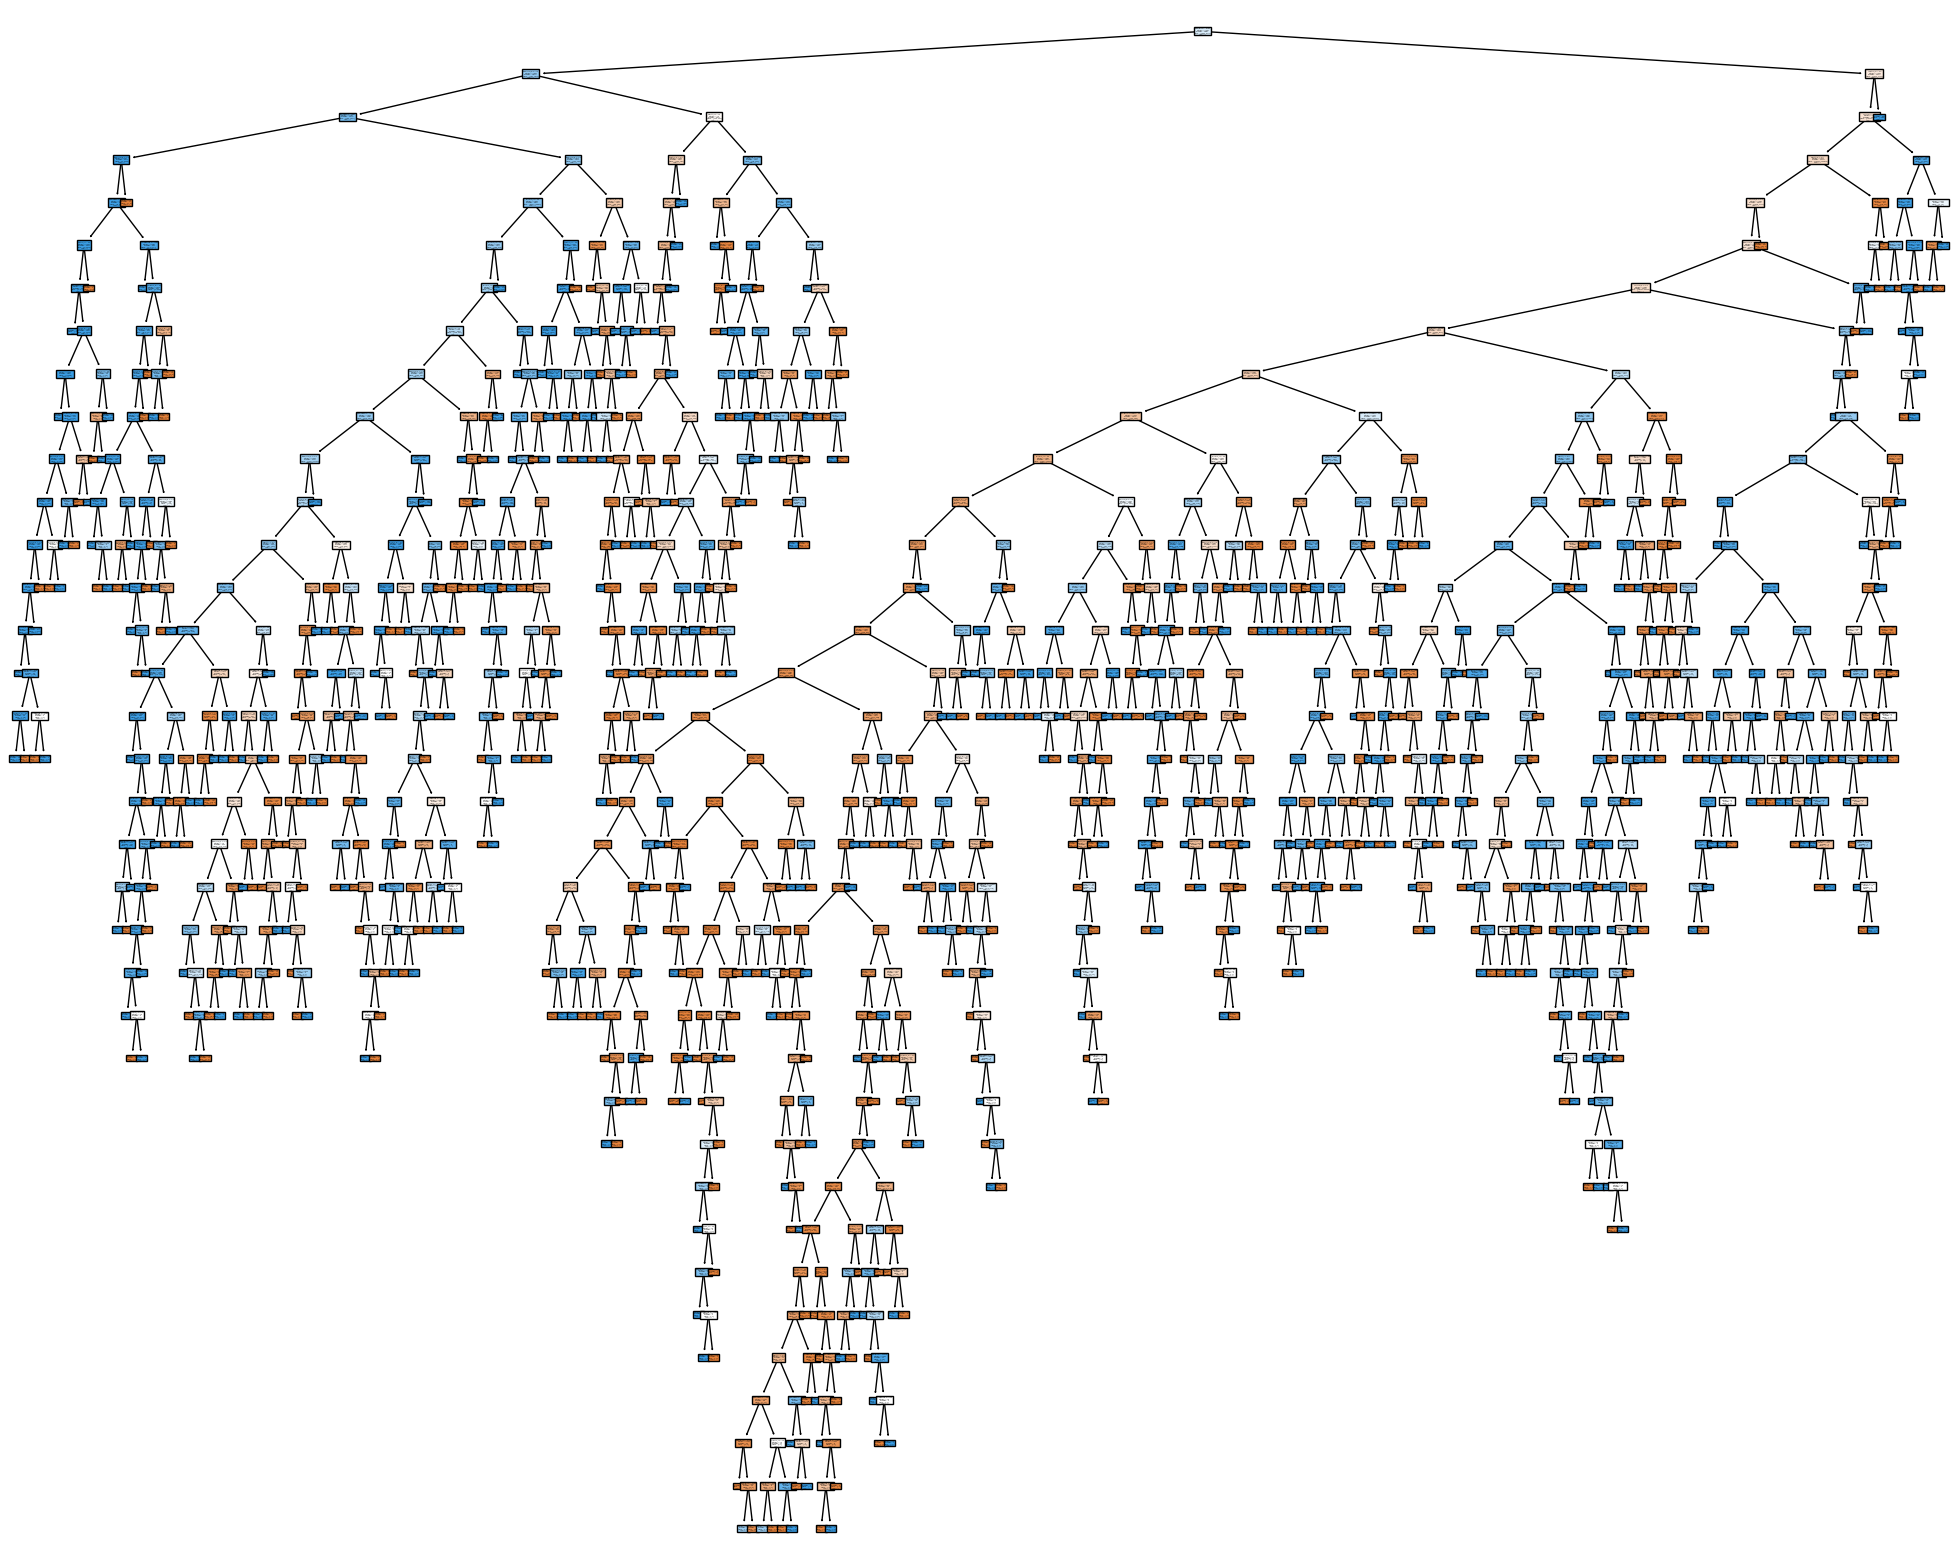

In [79]:
tree_plot(best_model, list(test.columns)[1:], list(test['class'].astype(str).unique()))